# Chapter 18. Neural Networks

In [94]:
from __future__ import division
from collections import Counter
from functools import partial
from linear_algebra import dot
import math, random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

An [artificial neural network](https://en.wikipedia.org/wiki/Artificial_neural_network), also known as an [ANN](https://www.doc.ic.ac.uk/~nd/surprise_96/journal/vol4/cs11/report.html) is a predictive model motivated by the way (some scientists and scholars believe) the brain operates (in theory, anyway).  
Think of the brain as a collection of neurons wired together.  
Each neuron looks at the outputs of the other neurons that feed into it, does a calculation, and then either fires (if the calculation exceeds some threshold) or doesn't fire (if the threshold is not reached).  
ANNs consist of artificial neurons which perform similar calculations over their inputs.  
Neural networks can be used to solve a wide variety of problems including handwriting recognition and face identification, and are also widely used in [deep learning](https://en.wikipedia.org/wiki/Deep_learning).  
Most neural networks are "black boxes", meaning that inspecting their details doesn't give you much understanding of *how* they are solving a problem.  
Large ANNs can also be (very) difficult to train.  
Keeping those caveats in mind, artificial neural networks can be used to do some [amazing stuff](https://gizmodo.com/these-are-the-incredible-day-dreams-of-artificial-neura-1712226908), so let's dive in.

## Perceptrons

Pretty much the simplest neural network is the [perceptron](https://en.wikipedia.org/wiki/Perceptron), which approximates a single neuron with $n$ binary inputs.  
It computes a weighted sum of its inputs and "fires" if that weighted sum is zero or greater:

In [95]:
def step_function(x):
    return 1 if x >= 0 else 0

def perceptron_output(weights, bias, x):
    """ returns 1 if the perceptron 'fires', 0 if not """
    calculation = dot(weights, x) + bias
    return step_function(calculation)

The perceptron is simply distinguishing between the half spaces separated by the hyperplane of points x for which:

With properly chosen weights, perceptrons can solve a number of simple problems:

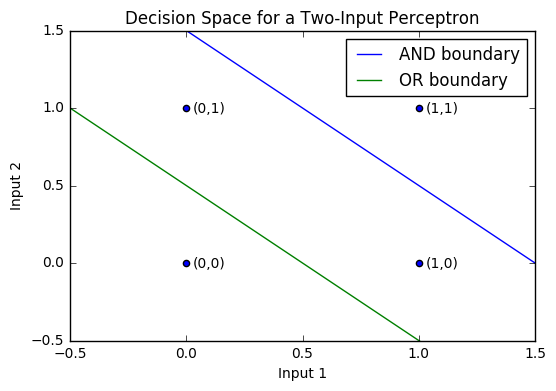

In [96]:
plt.scatter(0,1)
plt.annotate('(0,1)', xy=(0.03,0.97))
plt.scatter(1,0)
plt.annotate('(1,0)', xy=(1.03,-0.03))
plt.scatter(0,0)
plt.annotate('(0,0)', xy=(0.03,-0.03))
plt.scatter(1,1)
plt.annotate('(1,1)', xy=(1.03,0.97))
x1 = np.linspace(0, 1.5, 100)
y1 = np.linspace(1.5, 0, 100)
x2 = np.linspace(-1, 1.5, 100)
y2 = np.linspace(1.5, -1, 100)
plt.plot(x1,y1, label="AND boundary")
plt.plot(x2,y2, label="OR boundary")
plt.axis([-.5, 1.5, -.5, 1.5])
plt.title("Decision Space for a Two-Input Perceptron")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

For example, we can create an [AND gate](https://en.wikipedia.org/wiki/AND_gate) (which returns 1 if both of its inputs are 1 but returns 0 if either or both of its inputs are 0) with:

In [97]:
# If both inputs are 1, the `calculation` equals 2 + 2 - 3 = 1, and the output is 1:
print perceptron_output([2,2],-3,[1,1])

# If only one of the inputs is 1, the `calculation` equals 2 + 0 - 3 = -1, and the output is 0:
print perceptron_output([2,2],-3,[1,0])
print perceptron_output([2,2],-3,[0,1])

# If both inputs are 0, the `calculation` equals 0 + 0 - 3 = -3, and the output is 0:
print perceptron_output([2,2],-3,[0,0])

1
0
0
0


Similarly, we can build an [OR gate](https://en.wikipedia.org/wiki/OR_gate) with:

We could also build a [NOT gate](https://en.wikipedia.org/wiki/Inverter_%28logic_gate%29) (which has one input and converts 1 to 0 and 0 to 1) with:

However, there are some problems that simply can't be solved by a a single perceptron.  
For example, no matter how hard you try, you cannot use a perceptron to build an [XOR gate](https://en.wikipedia.org/wiki/XOR_gate) that outputs 1 if exactly one of its inputs is 1 and 0 otherwise.  
This is where we start needing more sophisticated (and complicated) neural networks.

You don't need to approximate a neuron in order to build a logic gate:

Like real neurons, artificial neurons become more interesting when you start connecting them together.

## Feed-Forward Neural Networks 

The topology of the brain is enormously complicated, so it's common to approximate it with an idealized [feed-forward neural network](https://en.wikipedia.org/wiki/Feedforward_neural_network) that consists of discrete layers of neurons, each connected to the next.  
This typically entails:
- an input layer which receives inputs and feeds them forward unchanged, 
- one or more "hidden layers", each of which consists of neurons that take the outputs of the previous layer, performs some calculation, and passes the result to the next layer, 
- and an output layer which produces the final outputs.

Just like the perceptron, each (non-input) neuron has a weight corresponding to each of its inputs and a bias.  
To make our representation simpler, we'll add the bias to the end of our weights vector and give each neuron a [bias input](https://stackoverflow.com/questions/2480650/role-of-bias-in-neural-networks) that always equals 1.  
As with the perceptron, for each neuron we'll sum up the products of its inputs as well as its weights.  
Here, however, rather than outputting the `step_function` applied to that product, we'll output a smooth approximation of the step function known as the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function):

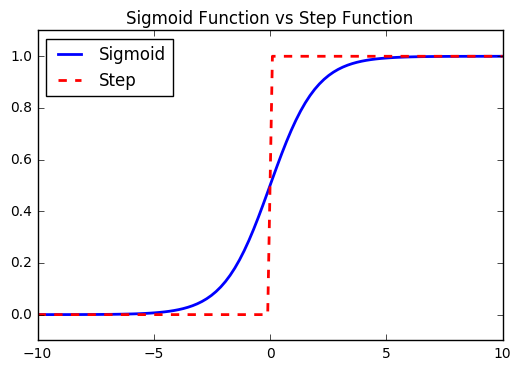

In [98]:
points = np.linspace(-10., 10., 100)
sigmoid = [1 / (1 + math.exp(-point)) for point in points]
step = [(1 if point >= 0 else 0) for point in points]
plt.axis([-10, 10, -0.1, 1.1])
plt.plot(points, sigmoid, lw=2, label="Sigmoid")
plt.plot(points, step, lw=2, ls='--', color='red', label="Step")
plt.title("Sigmoid Function vs Step Function")
plt.legend(loc=2)
plt.show()

In [99]:
def sigmoid(t):
    return 1 / (1 + math.exp(-t))

Why use `sigmoid` instead of the simpler `step_function`?  
In order to train a neural network, we'll need to use calculus, and in order to use calculus, we need *smooth* functions.  
The step function isn't even continuous, and `sigmoid` is a good smooth approximation of it.  
**Note**  
You may remember `sigmoid` from Chapter 16, where it was called `logistic`.  
Technically, 'sigmoid' refers to the *shape* of the function, and 'logistic' refers to that particular function, although the terms are often used interchangeably.

Now we can calculate the output as:

In [100]:
def neuron_output(weights, inputs):
    return sigmoid(dot(weights, inputs))

Given this function, we can represent a neuron simply as a list of weights whose length is one more than the number of inputs to that neuron (remember the bias weight).  
Then we can represent a neural network as a list of (non-input) [layers](http://pages.cs.wisc.edu/~bolo/shipyard/neural/local.html), where each layer is just a list of neurons in that layer.  
In other words, we are oing to represent a neural network as a list (layers) of lists (neurons) of lists (weights).  
Given such a representation, using the neural network is quite simple:

In [101]:
def feed_forward(neural_network, input_vector):
    """ takes in a neural network (represented as a list of lists of lists of weights) """
    """ and returns the output from forward-propagating the inputs """
    outputs = []
    # process one layer at a time
    for layer in neural_network:
        # add a bias input
        input_with_bias = input_vector + [1]
        # compute the output for each neuron
        output = [neuron_output(neuron, input_with_bias) for neuron in layer]
        # and remember it
        outputs.append(output)
        # the input to the next layer is the output of this one
        input_vector = output
    return outputs

Now we can build the XOR gate that we couldn't make with a single perceptron.  
We just need to scale the weights up so that the `neuron_outputs` are either really close to 0 or really close to 1:

In [102]:
xor_network = [# hidden layer
               [[20, 20, -30],    # 'and' neuron
                [20, 20, -10]],   # 'or' neuron
               # output layer
               [[-60, 60, -30]]]  # '2nd input but not 1st input' neuron

for x in [0, 1]:
    for y in [0, 1]:
        # feed_forward produces the outputs of every neuron
        # feed_forward[-1] is the outputs of the output-layer neurons
        print x, y, feed_forward(xor_network,[x, y])[-1]

0 0 [9.38314668300676e-14]
0 1 [0.9999999999999059]
1 0 [0.9999999999999059]
1 1 [9.383146683006828e-14]


By using a hidden layer, we are able to feed the output of an 'and' neuron and the output of an 'or' neuron into a 'second input but not first input' neuron.  
The result is a network that performs 'or, but *not* and,' which is precisely XOR.

![XOR_neural_network](img/XOR_neural_network.png)

## Backpropagation